# Plan


In [ ]:
# Ultimate goal: select a range of pixels, at various distances from isocenter, and plot the strength of the gradient field, minus the center frequency
# get a value of Hz/cm/tick for each of the gradients

# TODO:
# need to figure out a way to decently map the pixels to position from the images
# from the dicoms, extract the position and the RX of the image
# then select a bunch of pixels that have signal. heck could just use the whole image, based on a mask that shows where there is signal or there is not

# then for each pixel, get the position away from isocenter, and place on a plot the supposed gradient strength
# then fit a line to that, and get the gradient strength per tick


## Load the Tool
### Note: Have to restart the notebook every time you wish to make any changes to the shim tool itself...

In [1]:
import argparse
import json
import signal
import subprocess
import sys
import matplotlib.pyplot as plt
import tqdm
import time

In [2]:

sys.path.append('..')

# if tool is not defined name in the namespace
if "tool" in locals():
    tool.exsiInstance.stop()
    del tool

# print out the current path

from shimTool.Tool import Tool
from shimTool.dicomUtils import *
from shimTool.shimCompute import *

def load_config(filename):
    with open(filename, "r") as file:
        return json.load(file)

config = load_config("/home/heartvista/Documents/robert/ge3t_shim_tool/config.json")
tool = Tool(config, debugging=True)
#tool.exsiInstance.defaultCoil = "Head 24"


/home/heartvista/Documents/robert/ge3t_shim_tool/logs/scannerLog.txt
/home/heartvista/Documents/robert/ge3t_shim_tool/logs/arduinoLog.txt
/home/heartvista/Documents/robert/ge3t_shim_tool/logs/guiLog.txt
Debug: Failed to open serial port: [Errno 2] could not open port /dev/ttyACM1: [Errno 2] No such file or directory: '/dev/ttyACM1'
Debug SHIM CLIENT: Failed to start reading thread. Serial port is not open
INFO EXSI CLIENT: Socket connected
EXSI CLIENT DEBUG: Processing command:  ConnectToScanner product=newHV passwd=rTpAtD
10:44:19 SHIM TOOL: waiting for connection
EXSI CLIENT DEBUG: Processing command:  NotifyEvent all=on


EXSI CLIENT DEBUG: Processing command:  GetExamInfo
10:44:19 SHIM TOOL: done waiting for connection
EXSI CLIENT DEBUG: Processing command:  LoadProtocol site path="ConformalShimCalibration4"
EXSI CLIENT DEBUG: Task keys found in message:  [14]
EXSI CLIENT DEBUG: Processing command:  SelectTask taskkey=14
EXSI CLIENT DEBUG: Processing command:  ActivateTask
EXSI CLIENT DEBUG: Processing command:  PatientTable advanceToScan
EXSI CLIENT DEBUG: Processing command:  Scan
EXSI CLIENT DEBUG: Images are ready. in msg: <exsi-srv:27674:6012<NotifyEvent recon=done, 128 images available. taskKey=14 
EXSI CLIENT DEBUG: setting images_ready_event
EXSI CLIENT DEBUG: Processing command:  LoadProtocol site path="ConformalShimCalibration3"
EXSI CLIENT DEBUG: Task keys found in message:  [15, 16]
EXSI CLIENT DEBUG: Processing command:  SelectTask taskkey=15
EXSI CLIENT DEBUG: Processing command:  SetRxGeometry plane=coronal
EXSI CLIENT DEBUG: Processing command:  SetGrxSlices center=0.0,0.0,0 phaseNormal

In [3]:
def extractPixelSize(firstDCM):
    dcm = pydicom.dcmread(firstDCM)
    # Extract X and Y pixel size from PixelSpacing
    if 'PixelSpacing' in dcm:
        pixel_spacing = dcm.PixelSpacing
        pixel_size_x, pixel_size_y = pixel_spacing
    else:
        raise ValueError("Pixel Spacing information is not available in this DICOM file.")
    
    # Extract Z pixel size from SpacingBetweenSlices or SliceThickness
    if 'SpacingBetweenSlices' in dcm:
        pixel_size_z = dcm.SpacingBetweenSlices
    elif 'SliceThickness' in dcm:
        pixel_size_z = dcm.SliceThickness
    else:
        raise ValueError("Z spacing information is not available in this DICOM file.")
    
    return [pixel_size_x, pixel_size_y, pixel_size_z]
    
def computeFieldmapFromLatestFieldmapScan(tool: Tool)->np.ndarray:
    b0maps = compute_b0maps(1, tool.localExamRootDir)
    return b0maps[0]

def computeFieldmapFromFirstSeriesName(n, localExamRootDir, threshFactor=0.4) -> List[np.ndarray]:
    # computes the fieldmap from n scans ago
    """Computes the last n b0maps from pairs"""
    n = n+1
    seriesPaths = listSubDirs(localExamRootDir)
    print(f"DEBUG: Found {len(seriesPaths)} seriesPaths")
    if n == 1:
        seriesPaths = seriesPaths[-2*n:]
    else:
        seriesPaths = seriesPaths[-n * 2 : - (n - 1) * 2]
    b0maps = []
    for i in range(0, 2, 2):
        phase1, te1, name1 = extractComplexImageData(seriesPaths[i], threshFactor=threshFactor)
        print(f"DEBUG: Extracted te1 {te1}, name1 {name1}")
        phase2, te2, name2 = extractComplexImageData(seriesPaths[i + 1], threshFactor=threshFactor)
        print(f"DEBUG: Extracted te2 {te2}, name2 {name2}")
        b0map = compute_b0map(phase1, phase2, te1, te2)
        b0maps.append(b0map)
    return b0maps[0]

def plotPixelFieldStrengthsVsPosition(fig, title, points, xlabel, ylabel, xlim, ylim):
    fig.scatter(points[:,0], points[:,1])
    fig.set_title(title)
    fig.set_xlabel(xlabel)
    fig.set_ylabel(ylabel)
    fig.set_xlim(xlim)
    fig.set_ylim(ylim)

def getFieldStrengthPoints(fieldmap, pixelSize, fovCenter=[0,0,0], title=None):
    """
    for each dimensional direction:
        - collapse all strengths onto one dimension
        - compute the relative distance for each pixel position using pixelSize
        - create list of points (distanceFromIsocenter, fieldStrength)
        - plot the points
        - plot a line of best fit
    """
    points = [[],[],[]]
    # i want to take every non nan pixel value in the fieldmap
    # then for each pixel, get the distance from fovCenter, and the field strength and add to points list
    def get_distances(pos):
        shape = fieldmap.shape
        ret = []
        for i in range(3):
            ret.append((pos[i] - (shape[i]/2+.5)) * pixelSize[i] + fovCenter[i])
        return ret

    maxDist=0
    for y in range(fieldmap.shape[0]):
        for z in range(fieldmap.shape[1]):
            for x in range(fieldmap.shape[2]):
                if not np.isnan(fieldmap[y,z,x]):
                    fieldStrength = fieldmap[y,z,x]
                    distances = get_distances([y,z,x])
                    maxDist = max(maxDist, np.max(np.abs(distances)))
                    for i in range(3):
                        points[i].append([distances[i], fieldStrength])

    if title is not None:
        directions = ["Y", "Z", "X"]
        absheight=0
        for i in range(3):
            points[i] = np.array(points[i])
            absheight = max(absheight, np.nanmax(np.abs(points[i][:,1])))

        fig, axs = plt.subplots(3, 1, figsize=(10, 30))
        for i in range(3):
            plotPixelFieldStrengthsVsPosition(
                axs[i], 
                f"{title} Field (Hz) vs Distance (mm) Isocenter in {directions[i]}", 
                points[i], 
                "Distance from Isocenter (mm)", 
                "Field Strength (Hz)", 
                [-maxDist, maxDist], 
                [-absheight, absheight]
            )
        plt.show()
    return [points[2], points[0], points[1]]


In [ ]:
seriesPaths = listSubDirs(tool.localExamRootDir)
print(seriesPaths)

#### Need to figure out how to modify one gradient strength and take a second fieldmap.


In [ ]:
latestDCMDir = listSubDirs(tool.localExamRootDir)[-1]
firstDCM = listDicomFiles(latestDCMDir)[0]
pixelSize = extractPixelSize(firstDCM)
background = computeFieldmapFromLatestFieldmapScan(tool)
 

In [ ]:
# tool.setLinGradients([50, 0, 0])
# tool.doFieldmapScan()
fieldmapx = computeFieldmapFromFirstSeriesName(2, tool.localExamRootDir)
fieldmapx = fieldmapx - background

xgradPoints = getFieldStrengthPoints(fieldmapx, pixelSize, "X Grad 50")[0]

# tool.setLinGradients([0, 50, 0])
# tool.doFieldmapScan()
fieldmapy = computeFieldmapFromFirstSeriesName(1, tool.localExamRootDir)
fieldmapy = fieldmapy - background

ygradPoints = getFieldStrengthPoints(fieldmapy, pixelSize, "Y Grad 50")[1]

# tool.setLinGradients([0, 0, 50])
# tool.doFieldmapScan()
fieldmapz = computeFieldmapFromFirstSeriesName(0, tool.localExamRootDir)
fieldmapz = fieldmapz - background

zgradPoints = getFieldStrengthPoints(fieldmapz, pixelSize, "Z Grad 50")[2]

#### now fit a line to each of them and get the slope, for 50 grad in this case...

In [ ]:
points = [xgradPoints, ygradPoints, zgradPoints]

for i in range(3):
    # get the slope of the line of best fit
    points[i] = np.array(points[i])
    x = points[i][:,0]
    y = points[i][:,1]
    m, b = np.polyfit(x, y, 1)
    label = ["X", "Y", "Z"]
    print(f"Gradient {label[i]} with ticks set to 50: {m} Hz/mm ")
    print(f"\tGradient {label[i]}: {m/50} Hz/mm/tick")
    

## Write code to automate:

In [11]:
def collectTickReferences(gradientTicks, centerPos):
    tool.autoPrescanDone = False
    tool.exsiInstance.bedPosition = centerPos[2]
    tool.doFieldmapScan()
    latestDCMDir = listSubDirs(tool.localExamRootDir)[-1]
    firstDCM = listDicomFiles(latestDCMDir)[0]
    pixelSize = extractPixelSize(firstDCM)
    background = computeFieldmapFromLatestFieldmapScan(tool)
    print("=============================== Background Done ================================")
    tickToGradStrengths = []
    for i in tqdm.tqdm(range(3), desc="Gradients", position=0):
        slopes = []
        gradientToSet = [0,0,0]
        for ticks in tqdm.tqdm(gradientTicks, desc="Ticks", position=1):
            label = ["X", "Y", "Z"]
            print(f"Doing gradient {label[i]} with ticks set to {ticks}")
            gradientToSet[i] = ticks
            tool.setLinGradients(gradientToSet)
            tool.doFieldmapScan()
            fieldmap = computeFieldmapFromLatestFieldmapScan(tool)
            fieldmap = fieldmap - background
            points = np.array(getFieldStrengthPoints(fieldmap, pixelSize, centerPos)[i])
            x = points[:,0]
            y = points[:,1]
            m, b = np.polyfit(x, y, 1)
            print(f"Gradient {label[i]} with ticks set to {ticks}: {m} Hz/mm ")
            print(f"\tGradient {label[i]}: {m/ticks} Hz/mm/tick")
            print("--------------------------------------------------------------")
            slopes.append([ticks, m/ticks])
        tickToGradStrengths.append(slopes)
    return tickToGradStrengths

# plot the points from each gradient direction as a scatter plot with different colors. 
# on the x axis should be the strength set for the gradient, on the y axis should be the computed strength of the gradient per tick
# plot all three sets on the same graph

# Plot the points from each gradient direction as a scatter plot with different colors
def plotTickReferences(tickToGradStrengths, centerFOV=[0,0,0]):
    for i in range(3):
        tickToGradStrengths[i] = np.array(tickToGradStrengths[i])
    plt.scatter(tickToGradStrengths[0][:, 0], tickToGradStrengths[0][:, 1], color='red', label='Gradient X')
    plt.scatter(tickToGradStrengths[1][:, 0], tickToGradStrengths[1][:, 1], color='green', label='Gradient Y')
    plt.scatter(tickToGradStrengths[2][:, 0], tickToGradStrengths[2][:, 1], color='blue', label='Gradient Z')

    # Set labels and title
    plt.xlabel('Strength set for the gradient (Hz/mm/tick)')
    plt.ylabel('Gradient Strength Applied (ticks)')
    plt.title(f'Observed gradient strength granularity, with FOV Center at {centerFOV}')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

In [5]:
gradientTicksfine = list(range(-20,0,4)) + list(range(4,21,4))
gradientTicks = list(range(-80,0,20)) + gradientTicksfine + list(range(20,81,20))

### Collect some data

In [6]:
tool.doCalibrationScan()

10:44:47 SHIM TOOL: Initiating transfer using rsync.
10:44:48 SHIM TOOL: obtained exam data path: /export/home1/sdc_image_pool/images/p2/e2010


In [7]:
centerPos = [0,0,0]
tickToGradStrengthsCEntered = collectTickReferences(gradientTicks, centerPos)

10:44:48 SHIM TOOL: resetting???
10:44:48 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:44:48 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:45:32 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:45:32 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:45:55 SHIM TOOL: Done. 2 scans completed!
10:45:55 SHIM TOOL: Initiating transfer using rsync.
10:45:56 SHIM TOOL: Initiating transfer using rsync.
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd
10:45:57 SHIM TOOL: Computed Mask from background, basis and ROI.
10:45:57 SHIM TOOL: Masked obtained data and 'sent to GUI.'
10:45:57 SHIM TOOL: evaluating map 0
10:45:57 SHIM TOOL: finished setting the per slice stats for map 0
10:45:57 SHIM TOOL: finished setting the volume stats for map 0
10:45:57 SHIM TOOL: ev

Gradients:   0%|          | 0/3 [00:00<?, ?it/s]

Doing gradient X with ticks set to -80
10:45:57 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [-74.   9. -60.]
10:45:57 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:45:57 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:46:22 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:46:22 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:46:45 SHIM TOOL: Done. 2 scans completed!
10:46:45 SHIM TOOL: Initiating transfer using rsync.
10:46:46 SHIM TOOL: Initiating transfer using rsync.
10:46:47 SHIM TOOL: evaluating map 0
10:46:47 SHIM TOOL: finished setting the per slice stats for map 0
10:46:47 SHIM TOOL: finished setting the volume stats for map 0
10:46:47 SHIM TOOL: evaluating map 1
10:46:47 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extr

Gradient X with ticks set to -80: -3.653887725622856 Hz/mm 
	Gradient X: 0.045673596570285704 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to -60
10:46:48 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [-54.   9. -60.]
10:46:48 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:46:48 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:47:12 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:47:12 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:47:36 SHIM TOOL: Done. 2 scans completed!
10:47:36 SHIM TOOL: Initiating transfer using rsync.
10:47:37 SHIM TOOL: Initiating transfer using rsync.
10:47:37 SHIM TOOL: evaluating map 0
10:47:37 SHIM TOOL: finished setting the per slice stats for map 0
10:47:37 SHIM TOOL

Gradient X with ticks set to -60: -2.741644510394218 Hz/mm 
	Gradient X: 0.04569407517323697 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to -40
10:47:38 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [-34.   9. -60.]
10:47:38 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:47:38 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:48:03 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:48:03 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:48:27 SHIM TOOL: Done. 2 scans completed!
10:48:27 SHIM TOOL: Initiating transfer using rsync.
10:48:28 SHIM TOOL: Initiating transfer using rsync.
10:48:28 SHIM TOOL: evaluating map 0
10:48:28 SHIM TOOL: finished setting the per slice stats for map 0
10:48:28 SHIM TOOL:

Gradient X with ticks set to -40: -1.8466050959435028 Hz/mm 
	Gradient X: 0.046165127398587566 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to -20
10:48:29 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [-14.   9. -60.]
10:48:29 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:48:29 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:48:54 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:48:54 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:49:18 SHIM TOOL: Done. 2 scans completed!
10:49:18 SHIM TOOL: Initiating transfer using rsync.
10:49:18 SHIM TOOL: Initiating transfer using rsync.
10:49:19 SHIM TOOL: evaluating map 0
10:49:19 SHIM TOOL: finished setting the per slice stats for map 0
10:49:19 SHIM TOO

Gradient X with ticks set to -20: -0.9255011145719428 Hz/mm 
	Gradient X: 0.04627505572859714 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to -20
10:49:20 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [-14.   9. -60.]
10:49:20 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:49:20 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:49:44 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:49:44 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:50:08 SHIM TOOL: Done. 2 scans completed!
10:50:08 SHIM TOOL: Initiating transfer using rsync.
10:50:09 SHIM TOOL: Initiating transfer using rsync.
10:50:10 SHIM TOOL: evaluating map 0
10:50:10 SHIM TOOL: finished setting the per slice stats for map 0
10:50:10 SHIM TOOL

Gradient X with ticks set to -20: -0.9233788214870118 Hz/mm 
	Gradient X: 0.046168941074350586 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to -16
10:50:11 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [-10.   9. -60.]
10:50:11 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:50:11 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:50:35 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:50:35 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:50:59 SHIM TOOL: Done. 2 scans completed!
10:50:59 SHIM TOOL: Initiating transfer using rsync.
10:51:00 SHIM TOOL: Initiating transfer using rsync.
10:51:00 SHIM TOOL: evaluating map 0
10:51:00 SHIM TOOL: finished setting the per slice stats for map 0
10:51:00 SHIM TOO

Gradient X with ticks set to -16: -0.7216189110548067 Hz/mm 
	Gradient X: 0.04510118194092542 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to -12
10:51:01 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [ -6.   9. -60.]
10:51:01 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:51:01 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:51:26 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:51:26 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:51:50 SHIM TOOL: Done. 2 scans completed!
10:51:50 SHIM TOOL: Initiating transfer using rsync.
10:51:50 SHIM TOOL: Initiating transfer using rsync.
10:51:51 SHIM TOOL: evaluating map 0
10:51:51 SHIM TOOL: finished setting the per slice stats for map 0
10:51:51 SHIM TOOL

Gradient X with ticks set to -12: -0.5451467853062256 Hz/mm 
	Gradient X: 0.045428898775518804 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to -8
10:51:52 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [ -2.   9. -60.]
10:51:52 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:51:52 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:52:16 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:52:16 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:52:40 SHIM TOOL: Done. 2 scans completed!
10:52:40 SHIM TOOL: Initiating transfer using rsync.
10:52:41 SHIM TOOL: Initiating transfer using rsync.
10:52:41 SHIM TOOL: evaluating map 0
10:52:41 SHIM TOOL: finished setting the per slice stats for map 0
10:52:41 SHIM TOOL

Gradient X with ticks set to -8: -0.36498788078457717 Hz/mm 
	Gradient X: 0.045623485098072146 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to -4
10:52:42 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  2.   9. -60.]
10:52:42 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:52:42 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:53:07 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:53:07 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:53:31 SHIM TOOL: Done. 2 scans completed!
10:53:31 SHIM TOOL: Initiating transfer using rsync.
10:53:31 SHIM TOOL: Initiating transfer using rsync.
10:53:32 SHIM TOOL: evaluating map 0
10:53:32 SHIM TOOL: finished setting the per slice stats for map 0
10:53:32 SHIM TOOL

Gradient X with ticks set to -4: -0.1782892289724364 Hz/mm 
	Gradient X: 0.0445723072431091 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to 4
10:53:33 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [ 10.   9. -60.]
10:53:33 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:53:33 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:53:58 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:53:58 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:54:22 SHIM TOOL: Done. 2 scans completed!
10:54:22 SHIM TOOL: Initiating transfer using rsync.
10:54:22 SHIM TOOL: Initiating transfer using rsync.
10:54:23 SHIM TOOL: evaluating map 0
10:54:23 SHIM TOOL: finished setting the per slice stats for map 0
10:54:23 SHIM TOOL: fi

Gradient X with ticks set to 4: 0.17007456368696663 Hz/mm 
	Gradient X: 0.04251864092174166 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to 8
10:54:24 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [ 14.   9. -60.]
10:54:24 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:54:24 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:54:48 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:54:48 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:55:12 SHIM TOOL: Done. 2 scans completed!
10:55:12 SHIM TOOL: Initiating transfer using rsync.
10:55:13 SHIM TOOL: Initiating transfer using rsync.
10:55:13 SHIM TOOL: evaluating map 0
10:55:13 SHIM TOOL: finished setting the per slice stats for map 0
10:55:13 SHIM TOOL: fi

Gradient X with ticks set to 8: 0.3529223156324706 Hz/mm 
	Gradient X: 0.04411528945405883 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to 12
10:55:15 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [ 18.   9. -60.]
10:55:15 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:55:15 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:55:39 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:55:39 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:56:03 SHIM TOOL: Done. 2 scans completed!
10:56:03 SHIM TOOL: Initiating transfer using rsync.
10:56:03 SHIM TOOL: Initiating transfer using rsync.
10:56:04 SHIM TOOL: evaluating map 0
10:56:04 SHIM TOOL: finished setting the per slice stats for map 0
10:56:04 SHIM TOOL: fi

Gradient X with ticks set to 12: 0.5243667005876407 Hz/mm 
	Gradient X: 0.043697225048970056 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to 16
10:56:05 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [ 22.   9. -60.]
10:56:05 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:56:05 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:56:30 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:56:30 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:56:53 SHIM TOOL: Done. 2 scans completed!
10:56:53 SHIM TOOL: Initiating transfer using rsync.
10:56:54 SHIM TOOL: Initiating transfer using rsync.
10:56:55 SHIM TOOL: evaluating map 0
10:56:55 SHIM TOOL: finished setting the per slice stats for map 0
10:56:55 SHIM TOOL: 

Gradient X with ticks set to 16: 0.7127304937808496 Hz/mm 
	Gradient X: 0.0445456558613031 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to 20
10:56:56 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [ 26.   9. -60.]
10:56:56 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:56:56 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:57:20 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:57:20 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:57:44 SHIM TOOL: Done. 2 scans completed!
10:57:44 SHIM TOOL: Initiating transfer using rsync.
10:57:45 SHIM TOOL: Initiating transfer using rsync.
10:57:45 SHIM TOOL: evaluating map 0
10:57:45 SHIM TOOL: finished setting the per slice stats for map 0
10:57:45 SHIM TOOL: fi

Gradient X with ticks set to 20: 0.910328012283448 Hz/mm 
	Gradient X: 0.0455164006141724 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to 20
10:57:47 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [ 26.   9. -60.]
10:57:47 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:57:47 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:58:11 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:58:11 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:58:36 SHIM TOOL: Done. 2 scans completed!
10:58:36 SHIM TOOL: Initiating transfer using rsync.
10:58:36 SHIM TOOL: Initiating transfer using rsync.
10:58:37 SHIM TOOL: evaluating map 0
10:58:37 SHIM TOOL: finished setting the per slice stats for map 0
10:58:37 SHIM TOOL: fin

Gradient X with ticks set to 20: 0.9132560476915441 Hz/mm 
	Gradient X: 0.045662802384577206 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to 40
10:58:38 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [ 46.   9. -60.]
10:58:38 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:58:38 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:59:03 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:59:03 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
10:59:27 SHIM TOOL: Done. 2 scans completed!
10:59:27 SHIM TOOL: Initiating transfer using rsync.
10:59:27 SHIM TOOL: Initiating transfer using rsync.
10:59:28 SHIM TOOL: evaluating map 0
10:59:28 SHIM TOOL: finished setting the per slice stats for map 0
10:59:28 SHIM TOOL: 

Gradient X with ticks set to 40: 1.7229989527007876 Hz/mm 
	Gradient X: 0.04307497381751969 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to 60
10:59:29 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [ 66.   9. -60.]
10:59:29 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
10:59:29 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
10:59:53 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
10:59:53 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:00:18 SHIM TOOL: Done. 2 scans completed!
11:00:18 SHIM TOOL: Initiating transfer using rsync.
11:00:18 SHIM TOOL: Initiating transfer using rsync.
11:00:19 SHIM TOOL: evaluating map 0
11:00:19 SHIM TOOL: finished setting the per slice stats for map 0
11:00:19 SHIM TOOL: f

Gradient X with ticks set to 60: 2.620934653987884 Hz/mm 
	Gradient X: 0.0436822442331314 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to 80
11:00:20 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [ 86.   9. -60.]
11:00:20 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:00:20 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:00:46 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:00:46 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:01:09 SHIM TOOL: Done. 2 scans completed!
11:01:09 SHIM TOOL: Initiating transfer using rsync.
11:01:10 SHIM TOOL: Initiating transfer using rsync.
11:01:10 SHIM TOOL: evaluating map 0
11:01:11 SHIM TOOL: finished setting the per slice stats for map 0
11:01:11 SHIM TOOL: fin

Gradients:  33%|███▎      | 1/3 [15:14<30:28, 914.21s/it]

Gradient X with ticks set to 80: 3.52399580743966 Hz/mm 
	Gradient X: 0.04404994759299575 Hz/mm/tick
--------------------------------------------------------------


Doing gradient Y with ticks set to -80
11:01:12 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6. -71. -60.]
11:01:12 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:01:12 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:01:37 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:01:37 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:02:00 SHIM TOOL: Done. 2 scans completed!
11:02:00 SHIM TOOL: Initiating transfer using rsync.
11:02:01 SHIM TOOL: Initiating transfer using rsync.
11:02:01 SHIM TOOL: evaluating map 0
11:02:01 SHIM TOOL: finished setting the per slice stats for map 0
11:02:01 SHIM TOOL: finished setting the volume stats for map 0
11:02:01 SHIM TOOL: evaluating map 1
11:02:01 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extr

Gradient Y with ticks set to -80: -3.660942348936337 Hz/mm 
	Gradient Y: 0.04576177936170421 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to -60
11:02:03 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6. -51. -60.]
11:02:03 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:02:03 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:02:27 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:02:27 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:02:51 SHIM TOOL: Done. 2 scans completed!
11:02:51 SHIM TOOL: Initiating transfer using rsync.
11:02:52 SHIM TOOL: Initiating transfer using rsync.
11:02:52 SHIM TOOL: evaluating map 0
11:02:52 SHIM TOOL: finished setting the per slice stats for map 0
11:02:52 SHIM TOOL:

Gradient Y with ticks set to -60: -2.6397729678671014 Hz/mm 
	Gradient Y: 0.04399621613111836 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to -40
11:02:53 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6. -31. -60.]
11:02:53 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:02:53 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:03:18 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:03:18 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:03:42 SHIM TOOL: Done. 2 scans completed!
11:03:42 SHIM TOOL: Initiating transfer using rsync.
11:03:43 SHIM TOOL: Initiating transfer using rsync.
11:03:43 SHIM TOOL: evaluating map 0
11:03:43 SHIM TOOL: finished setting the per slice stats for map 0
11:03:43 SHIM TOOL

Gradient Y with ticks set to -40: -1.842931604239718 Hz/mm 
	Gradient Y: 0.046073290105992946 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to -20
11:03:44 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6. -11. -60.]
11:03:44 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:03:44 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:04:09 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:04:09 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:04:33 SHIM TOOL: Done. 2 scans completed!
11:04:33 SHIM TOOL: Initiating transfer using rsync.
11:04:34 SHIM TOOL: Initiating transfer using rsync.
11:04:34 SHIM TOOL: evaluating map 0
11:04:34 SHIM TOOL: finished setting the per slice stats for map 0
11:04:34 SHIM TOOL

Gradient Y with ticks set to -20: -0.9149073143900235 Hz/mm 
	Gradient Y: 0.04574536571950118 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to -20
11:04:35 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6. -11. -60.]
11:04:35 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:04:35 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:05:00 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:05:00 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:05:24 SHIM TOOL: Done. 2 scans completed!
11:05:24 SHIM TOOL: Initiating transfer using rsync.
11:05:25 SHIM TOOL: Initiating transfer using rsync.
11:05:26 SHIM TOOL: evaluating map 0
11:05:26 SHIM TOOL: finished setting the per slice stats for map 0
11:05:26 SHIM TOOL

Gradient Y with ticks set to -20: -0.9204336892438233 Hz/mm 
	Gradient Y: 0.04602168446219117 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to -16
11:05:27 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.  -7. -60.]
11:05:27 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:05:27 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:05:52 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:05:52 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:06:15 SHIM TOOL: Done. 2 scans completed!
11:06:15 SHIM TOOL: Initiating transfer using rsync.
11:06:16 SHIM TOOL: Initiating transfer using rsync.
11:06:17 SHIM TOOL: evaluating map 0
11:06:17 SHIM TOOL: finished setting the per slice stats for map 0
11:06:17 SHIM TOOL

Gradient Y with ticks set to -16: -0.7606144826227202 Hz/mm 
	Gradient Y: 0.047538405163920015 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to -12
11:06:18 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.  -3. -60.]
11:06:18 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:06:18 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:06:42 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:06:42 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:07:06 SHIM TOOL: Done. 2 scans completed!
11:07:06 SHIM TOOL: Initiating transfer using rsync.
11:07:07 SHIM TOOL: Initiating transfer using rsync.
11:07:08 SHIM TOOL: evaluating map 0
11:07:08 SHIM TOOL: finished setting the per slice stats for map 0
11:07:08 SHIM TOO

Gradient Y with ticks set to -12: -0.5514699635011746 Hz/mm 
	Gradient Y: 0.04595583029176455 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to -8
11:07:09 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.   1. -60.]
11:07:09 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:07:09 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:07:34 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:07:34 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:07:57 SHIM TOOL: Done. 2 scans completed!
11:07:57 SHIM TOOL: Initiating transfer using rsync.
11:07:58 SHIM TOOL: Initiating transfer using rsync.
11:07:59 SHIM TOOL: evaluating map 0
11:07:59 SHIM TOOL: finished setting the per slice stats for map 0
11:07:59 SHIM TOOL:

Gradient Y with ticks set to -8: -0.3530771404495302 Hz/mm 
	Gradient Y: 0.044134642556191275 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to -4
11:08:00 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.   5. -60.]
11:08:00 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:08:00 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:08:24 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:08:24 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:08:49 SHIM TOOL: Done. 2 scans completed!
11:08:49 SHIM TOOL: Initiating transfer using rsync.
11:08:49 SHIM TOOL: Initiating transfer using rsync.
11:08:50 SHIM TOOL: evaluating map 0
11:08:50 SHIM TOOL: finished setting the per slice stats for map 0
11:08:50 SHIM TOOL:

Gradient Y with ticks set to -4: -0.18515052597009862 Hz/mm 
	Gradient Y: 0.046287631492524656 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to 4
11:08:51 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.  13. -60.]
11:08:51 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:08:51 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:09:16 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:09:16 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:09:40 SHIM TOOL: Done. 2 scans completed!
11:09:40 SHIM TOOL: Initiating transfer using rsync.
11:09:41 SHIM TOOL: Initiating transfer using rsync.
11:09:41 SHIM TOOL: evaluating map 0
11:09:41 SHIM TOOL: finished setting the per slice stats for map 0
11:09:41 SHIM TOOL:

Gradient Y with ticks set to 4: 0.18254423722753227 Hz/mm 
	Gradient Y: 0.04563605930688307 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to 8
11:09:42 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.  17. -60.]
11:09:42 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:09:42 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:10:07 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:10:07 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:10:32 SHIM TOOL: Done. 2 scans completed!
11:10:32 SHIM TOOL: Initiating transfer using rsync.
11:10:33 SHIM TOOL: Initiating transfer using rsync.
11:10:33 SHIM TOOL: evaluating map 0
11:10:33 SHIM TOOL: finished setting the per slice stats for map 0
11:10:33 SHIM TOOL: fi

Gradient Y with ticks set to 8: 0.3495714350773119 Hz/mm 
	Gradient Y: 0.04369642938466399 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to 12
11:10:35 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.  21. -60.]
11:10:35 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:10:35 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:10:59 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:10:59 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:11:23 SHIM TOOL: Done. 2 scans completed!
11:11:23 SHIM TOOL: Initiating transfer using rsync.
11:11:24 SHIM TOOL: Initiating transfer using rsync.
11:11:25 SHIM TOOL: evaluating map 0
11:11:25 SHIM TOOL: finished setting the per slice stats for map 0
11:11:25 SHIM TOOL: fi

Gradient Y with ticks set to 12: 0.5394090827075302 Hz/mm 
	Gradient Y: 0.044950756892294184 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to 16
11:11:26 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.  25. -60.]
11:11:26 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:11:26 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:11:51 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:11:51 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:12:14 SHIM TOOL: Done. 2 scans completed!
11:12:14 SHIM TOOL: Initiating transfer using rsync.
11:12:15 SHIM TOOL: Initiating transfer using rsync.
11:12:16 SHIM TOOL: evaluating map 0
11:12:16 SHIM TOOL: finished setting the per slice stats for map 0
11:12:16 SHIM TOOL: 

Gradient Y with ticks set to 16: 0.7265415977015126 Hz/mm 
	Gradient Y: 0.04540884985634454 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to 20
11:12:17 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.  29. -60.]
11:12:17 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:12:17 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:12:41 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:12:41 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:13:06 SHIM TOOL: Done. 2 scans completed!
11:13:06 SHIM TOOL: Initiating transfer using rsync.
11:13:06 SHIM TOOL: Initiating transfer using rsync.
11:13:07 SHIM TOOL: evaluating map 0
11:13:07 SHIM TOOL: finished setting the per slice stats for map 0
11:13:07 SHIM TOOL: f

Gradient Y with ticks set to 20: 0.8539456043071723 Hz/mm 
	Gradient Y: 0.04269728021535861 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to 20
11:13:08 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.  29. -60.]
11:13:08 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:13:08 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:13:33 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:13:33 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:13:57 SHIM TOOL: Done. 2 scans completed!
11:13:57 SHIM TOOL: Initiating transfer using rsync.
11:13:58 SHIM TOOL: Initiating transfer using rsync.
11:13:58 SHIM TOOL: evaluating map 0
11:13:58 SHIM TOOL: finished setting the per slice stats for map 0
11:13:58 SHIM TOOL: f

Gradient Y with ticks set to 20: 0.8581535661341093 Hz/mm 
	Gradient Y: 0.042907678306705464 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to 40
11:13:59 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.  49. -60.]
11:13:59 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:13:59 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:14:25 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:14:25 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:14:49 SHIM TOOL: Done. 2 scans completed!
11:14:49 SHIM TOOL: Initiating transfer using rsync.
11:14:50 SHIM TOOL: Initiating transfer using rsync.
11:14:51 SHIM TOOL: evaluating map 0
11:14:51 SHIM TOOL: finished setting the per slice stats for map 0
11:14:51 SHIM TOOL: 

Gradient Y with ticks set to 40: 1.8183467502267352 Hz/mm 
	Gradient Y: 0.04545866875566838 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to 60
11:14:52 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.  69. -60.]
11:14:52 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:14:52 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:15:16 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:15:16 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:15:41 SHIM TOOL: Done. 2 scans completed!
11:15:41 SHIM TOOL: Initiating transfer using rsync.
11:15:41 SHIM TOOL: Initiating transfer using rsync.
11:15:42 SHIM TOOL: evaluating map 0
11:15:42 SHIM TOOL: finished setting the per slice stats for map 0
11:15:42 SHIM TOOL: f

Gradient Y with ticks set to 60: 2.689491496888988 Hz/mm 
	Gradient Y: 0.04482485828148313 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to 80
11:15:43 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.  89. -60.]
11:15:43 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:15:43 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:16:08 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:16:08 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:16:32 SHIM TOOL: Done. 2 scans completed!
11:16:32 SHIM TOOL: Initiating transfer using rsync.
11:16:33 SHIM TOOL: Initiating transfer using rsync.
11:16:33 SHIM TOOL: evaluating map 0
11:16:33 SHIM TOOL: finished setting the per slice stats for map 0
11:16:33 SHIM TOOL: fi

Gradients:  67%|██████▋   | 2/3 [30:36<15:19, 919.19s/it]

Gradient Y with ticks set to 80: 3.6834962080253737 Hz/mm 
	Gradient Y: 0.04604370260031717 Hz/mm/tick
--------------------------------------------------------------


Doing gradient Z with ticks set to -80
11:16:34 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [   6.    9. -140.]
11:16:34 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:16:34 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:16:59 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:16:59 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:17:23 SHIM TOOL: Done. 2 scans completed!
11:17:23 SHIM TOOL: Initiating transfer using rsync.
11:17:24 SHIM TOOL: Initiating transfer using rsync.
11:17:25 SHIM TOOL: evaluating map 0
11:17:25 SHIM TOOL: finished setting the per slice stats for map 0
11:17:25 SHIM TOOL: finished setting the volume stats for map 0
11:17:25 SHIM TOOL: evaluating map 1
11:17:25 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBUG: E

Gradient Z with ticks set to -80: -3.662614372129584 Hz/mm 
	Gradient Z: 0.0457826796516198 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to -60
11:17:26 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [   6.    9. -120.]
11:17:26 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:17:26 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:17:51 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:17:51 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:18:15 SHIM TOOL: Done. 2 scans completed!
11:18:15 SHIM TOOL: Initiating transfer using rsync.
11:18:15 SHIM TOOL: Initiating transfer using rsync.
11:18:16 SHIM TOOL: evaluating map 0
11:18:16 SHIM TOOL: finished setting the per slice stats for map 0
11:18:16 SHIM TOO

Gradient Z with ticks set to -60: -1.0015634106464164 Hz/mm 
	Gradient Z: 0.016692723510773607 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to -40
11:18:17 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [   6.    9. -100.]
11:18:17 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:18:17 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:18:42 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:18:42 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:19:06 SHIM TOOL: Done. 2 scans completed!
11:19:06 SHIM TOOL: Initiating transfer using rsync.
11:19:07 SHIM TOOL: Initiating transfer using rsync.
11:19:07 SHIM TOOL: evaluating map 0
11:19:07 SHIM TOOL: finished setting the per slice stats for map 0
11:19:07 SHIM 

Gradient Z with ticks set to -40: -1.8106891522846893 Hz/mm 
	Gradient Z: 0.045267228807117234 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to -20
11:19:08 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.   9. -80.]
11:19:08 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:19:08 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:19:33 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:19:33 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:19:57 SHIM TOOL: Done. 2 scans completed!
11:19:57 SHIM TOOL: Initiating transfer using rsync.
11:19:58 SHIM TOOL: Initiating transfer using rsync.
11:19:59 SHIM TOOL: evaluating map 0
11:19:59 SHIM TOOL: finished setting the per slice stats for map 0
11:19:59 SHIM TOO

Gradient Z with ticks set to -20: -0.9122200068139689 Hz/mm 
	Gradient Z: 0.04561100034069844 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to -20
11:20:00 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.   9. -80.]
11:20:00 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:20:00 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:20:25 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:20:25 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:20:49 SHIM TOOL: Done. 2 scans completed!
11:20:49 SHIM TOOL: Initiating transfer using rsync.
11:20:50 SHIM TOOL: Initiating transfer using rsync.
11:20:50 SHIM TOOL: evaluating map 0
11:20:50 SHIM TOOL: finished setting the per slice stats for map 0
11:20:50 SHIM TOOL

Gradient Z with ticks set to -20: -0.9110844587657455 Hz/mm 
	Gradient Z: 0.04555422293828727 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to -16
11:20:51 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.   9. -76.]
11:20:51 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:20:51 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:21:16 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:21:16 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:21:41 SHIM TOOL: Done. 2 scans completed!
11:21:41 SHIM TOOL: Initiating transfer using rsync.
11:21:41 SHIM TOOL: Initiating transfer using rsync.
11:21:42 SHIM TOOL: evaluating map 0
11:21:42 SHIM TOOL: finished setting the per slice stats for map 0
11:21:42 SHIM TOOL

Gradient Z with ticks set to -16: -0.7251279871308466 Hz/mm 
	Gradient Z: 0.04532049919567791 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to -12
11:21:43 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.   9. -72.]
11:21:43 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:21:43 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:22:09 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:22:09 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:22:33 SHIM TOOL: Done. 2 scans completed!
11:22:33 SHIM TOOL: Initiating transfer using rsync.
11:22:34 SHIM TOOL: Initiating transfer using rsync.
11:22:34 SHIM TOOL: evaluating map 0
11:22:34 SHIM TOOL: finished setting the per slice stats for map 0
11:22:34 SHIM TOOL

Gradient Z with ticks set to -12: -0.5424215089142731 Hz/mm 
	Gradient Z: 0.04520179240952276 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to -8
11:22:35 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.   9. -68.]
11:22:35 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:22:35 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:23:00 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:23:00 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:23:24 SHIM TOOL: Done. 2 scans completed!
11:23:24 SHIM TOOL: Initiating transfer using rsync.
11:23:25 SHIM TOOL: Initiating transfer using rsync.
11:23:26 SHIM TOOL: evaluating map 0
11:23:26 SHIM TOOL: finished setting the per slice stats for map 0
11:23:26 SHIM TOOL:

Gradient Z with ticks set to -8: -0.3701217277309718 Hz/mm 
	Gradient Z: 0.046265215966371474 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to -4
11:23:27 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.   9. -64.]
11:23:27 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:23:27 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:23:52 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:23:52 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:24:16 SHIM TOOL: Done. 2 scans completed!
11:24:16 SHIM TOOL: Initiating transfer using rsync.
11:24:17 SHIM TOOL: Initiating transfer using rsync.
11:24:17 SHIM TOOL: evaluating map 0
11:24:17 SHIM TOOL: finished setting the per slice stats for map 0
11:24:17 SHIM TOOL:

Gradient Z with ticks set to -4: -0.1772114225685467 Hz/mm 
	Gradient Z: 0.04430285564213667 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 4
11:24:18 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.   9. -56.]
11:24:18 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:24:18 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:24:44 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:24:44 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:25:08 SHIM TOOL: Done. 2 scans completed!
11:25:08 SHIM TOOL: Initiating transfer using rsync.
11:25:09 SHIM TOOL: Initiating transfer using rsync.
11:25:09 SHIM TOOL: evaluating map 0
11:25:09 SHIM TOOL: finished setting the per slice stats for map 0
11:25:09 SHIM TOOL: f

Gradient Z with ticks set to 4: 0.1786905261953438 Hz/mm 
	Gradient Z: 0.04467263154883595 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 8
11:25:10 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.   9. -52.]
11:25:10 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:25:10 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:25:36 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:25:36 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:26:00 SHIM TOOL: Done. 2 scans completed!
11:26:00 SHIM TOOL: Initiating transfer using rsync.
11:26:01 SHIM TOOL: Initiating transfer using rsync.
11:26:01 SHIM TOOL: evaluating map 0
11:26:01 SHIM TOOL: finished setting the per slice stats for map 0
11:26:01 SHIM TOOL: fin

Gradient Z with ticks set to 8: 0.3735362231823037 Hz/mm 
	Gradient Z: 0.04669202789778796 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 12
11:26:02 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.   9. -48.]
11:26:02 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:26:02 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:26:27 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:26:27 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:26:52 SHIM TOOL: Done. 2 scans completed!
11:26:52 SHIM TOOL: Initiating transfer using rsync.
11:26:53 SHIM TOOL: Initiating transfer using rsync.
11:26:53 SHIM TOOL: evaluating map 0
11:26:53 SHIM TOOL: finished setting the per slice stats for map 0
11:26:53 SHIM TOOL: fi

Gradient Z with ticks set to 12: 0.560322157211221 Hz/mm 
	Gradient Z: 0.046693513100935086 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 16
11:26:54 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.   9. -44.]
11:26:54 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:26:54 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:27:19 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:27:19 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:27:44 SHIM TOOL: Done. 2 scans completed!
11:27:44 SHIM TOOL: Initiating transfer using rsync.
11:27:44 SHIM TOOL: Initiating transfer using rsync.
11:27:45 SHIM TOOL: evaluating map 0
11:27:45 SHIM TOOL: finished setting the per slice stats for map 0
11:27:45 SHIM TOOL: f

Gradient Z with ticks set to 16: -1.0462294617000456 Hz/mm 
	Gradient Z: -0.06538934135625285 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 20
11:27:46 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.   9. -40.]
11:27:46 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:27:46 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:28:11 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:28:11 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:28:36 SHIM TOOL: Done. 2 scans completed!
11:28:36 SHIM TOOL: Initiating transfer using rsync.
11:28:37 SHIM TOOL: Initiating transfer using rsync.
11:28:37 SHIM TOOL: evaluating map 0
11:28:37 SHIM TOOL: finished setting the per slice stats for map 0
11:28:37 SHIM TOOL:

Gradient Z with ticks set to 20: 0.9019184719089921 Hz/mm 
	Gradient Z: 0.0450959235954496 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 20
11:28:39 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.   9. -40.]
11:28:39 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:28:39 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:29:05 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:29:05 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:29:29 SHIM TOOL: Done. 2 scans completed!
11:29:29 SHIM TOOL: Initiating transfer using rsync.
11:29:29 SHIM TOOL: Initiating transfer using rsync.
11:29:30 SHIM TOOL: evaluating map 0
11:29:30 SHIM TOOL: finished setting the per slice stats for map 0
11:29:30 SHIM TOOL: fi

Gradient Z with ticks set to 20: 0.9015806230903521 Hz/mm 
	Gradient Z: 0.045079031154517606 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 40
11:29:31 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [  6.   9. -20.]
11:29:31 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:29:31 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:29:56 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:29:56 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:30:21 SHIM TOOL: Done. 2 scans completed!
11:30:21 SHIM TOOL: Initiating transfer using rsync.
11:30:21 SHIM TOOL: Initiating transfer using rsync.
11:30:22 SHIM TOOL: evaluating map 0
11:30:22 SHIM TOOL: finished setting the per slice stats for map 0
11:30:22 SHIM TOOL: 

Gradient Z with ticks set to 40: 0.09306736254086286 Hz/mm 
	Gradient Z: 0.0023266840635215716 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 60
11:30:23 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [6. 9. 0.]
11:30:23 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:30:23 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:30:48 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:30:48 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:31:13 SHIM TOOL: Done. 2 scans completed!
11:31:13 SHIM TOOL: Initiating transfer using rsync.
11:31:13 SHIM TOOL: Initiating transfer using rsync.
11:31:14 SHIM TOOL: evaluating map 0
11:31:14 SHIM TOOL: finished setting the per slice stats for map 0
11:31:14 SHIM TOOL: fini

Gradient Z with ticks set to 60: 0.9430624366935844 Hz/mm 
	Gradient Z: 0.015717707278226405 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 80
11:31:15 SHIM TOOL: DEBUG: Setting linear gradients from [  6.   9. -60.] to [ 6.  9. 20.]
11:31:15 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:31:15 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, 0]
11:31:40 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:31:40 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:32:05 SHIM TOOL: Done. 2 scans completed!
11:32:05 SHIM TOOL: Initiating transfer using rsync.
11:32:06 SHIM TOOL: Initiating transfer using rsync.
11:32:06 SHIM TOOL: evaluating map 0
11:32:06 SHIM TOOL: finished setting the per slice stats for map 0
11:32:06 SHIM TOOL: fin

Gradients: 100%|██████████| 3/3 [46:09<00:00, 923.33s/it]

Gradient Z with ticks set to 80: 1.8386826450905347 Hz/mm 
	Gradient Z: 0.022983533063631684 Hz/mm/tick
--------------------------------------------------------------


TypeError: list indices must be integers or slices, not tuple

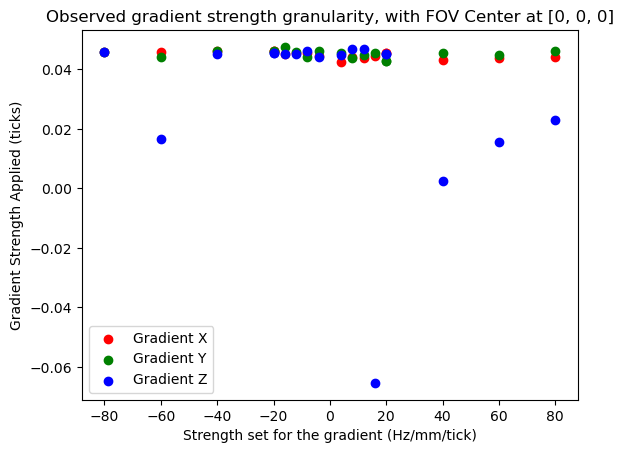

In [12]:
plotTickReferences(tickToGradStrengthsCEntered, centerPos)

In [13]:
gradientTicks = list(range(-60,0,20)) + list(range(20,81,20))
centerPos = [0,0,-50]

In [14]:
tickToGradStrengthsCEntered = collectTickReferences(gradientTicks, centerPos)

11:47:45 SHIM TOOL: resetting???
11:47:45 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:47:45 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
11:48:30 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:48:30 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:48:55 SHIM TOOL: Done. 2 scans completed!
11:48:55 SHIM TOOL: Initiating transfer using rsync.
11:48:56 SHIM TOOL: Initiating transfer using rsync.
11:48:56 SHIM TOOL: evaluating map 0
11:48:56 SHIM TOOL: finished setting the per slice stats for map 0
11:48:56 SHIM TOOL: finished setting the volume stats for map 0
11:48:56 SHIM TOOL: evaluating map 1
11:48:56 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd
=============================== Background Done ======================

Gradients:   0%|          | 0/3 [00:00<?, ?it/s]

Doing gradient X with ticks set to -60
11:48:57 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [-51.  11. -55.]
11:48:57 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:48:57 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
11:49:22 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:49:22 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:49:46 SHIM TOOL: Done. 2 scans completed!
11:49:46 SHIM TOOL: Initiating transfer using rsync.
11:49:47 SHIM TOOL: Initiating transfer using rsync.
11:49:47 SHIM TOOL: evaluating map 0
11:49:47 SHIM TOOL: finished setting the per slice stats for map 0
11:49:47 SHIM TOOL: finished setting the volume stats for map 0
11:49:47 SHIM TOOL: evaluating map 1
11:49:47 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBUG: 

Gradient X with ticks set to -60: -2.681611648866037 Hz/mm 
	Gradient X: 0.04469352748110062 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to -40
11:49:49 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [-31.  11. -55.]
11:49:49 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:49:49 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
11:50:14 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:50:14 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:50:38 SHIM TOOL: Done. 2 scans completed!
11:50:38 SHIM TOOL: Initiating transfer using rsync.
11:50:39 SHIM TOOL: Initiating transfer using rsync.
11:50:40 SHIM TOOL: evaluating map 0
11:50:40 SHIM TOOL: finished setting the per slice stats for map 0
11:50:40 SHIM T

Gradient X with ticks set to -40: -1.8025712883927378 Hz/mm 
	Gradient X: 0.045064282209818445 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to -20
11:50:41 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [-11.  11. -55.]
11:50:41 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:50:41 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
11:51:06 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:51:06 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:51:31 SHIM TOOL: Done. 2 scans completed!
11:51:31 SHIM TOOL: Initiating transfer using rsync.
11:51:32 SHIM TOOL: Initiating transfer using rsync.
11:51:32 SHIM TOOL: evaluating map 0
11:51:32 SHIM TOOL: finished setting the per slice stats for map 0
11:51:32 SHIM

Gradient X with ticks set to -20: -0.8938271538622954 Hz/mm 
	Gradient X: 0.04469135769311477 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to 20
11:51:34 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [ 29.  11. -55.]
11:51:34 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:51:34 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
11:51:59 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:51:59 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:52:24 SHIM TOOL: Done. 2 scans completed!
11:52:24 SHIM TOOL: Initiating transfer using rsync.
11:52:24 SHIM TOOL: Initiating transfer using rsync.
11:52:25 SHIM TOOL: evaluating map 0
11:52:25 SHIM TOOL: finished setting the per slice stats for map 0
11:52:25 SHIM T

Gradient X with ticks set to 20: 0.8867138488726607 Hz/mm 
	Gradient X: 0.044335692443633036 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to 40
11:52:26 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [ 49.  11. -55.]
11:52:26 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:52:26 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
11:52:51 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:52:51 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:53:16 SHIM TOOL: Done. 2 scans completed!
11:53:16 SHIM TOOL: Initiating transfer using rsync.
11:53:17 SHIM TOOL: Initiating transfer using rsync.
11:53:17 SHIM TOOL: evaluating map 0
11:53:17 SHIM TOOL: finished setting the per slice stats for map 0
11:53:17 SHIM TO

Gradient X with ticks set to 40: 1.7956667824744015 Hz/mm 
	Gradient X: 0.04489166956186004 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to 60
11:53:19 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [ 69.  11. -55.]
11:53:19 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:53:19 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
11:53:44 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:53:44 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:54:09 SHIM TOOL: Done. 2 scans completed!
11:54:09 SHIM TOOL: Initiating transfer using rsync.
11:54:10 SHIM TOOL: Initiating transfer using rsync.
11:54:10 SHIM TOOL: evaluating map 0
11:54:10 SHIM TOOL: finished setting the per slice stats for map 0
11:54:10 SHIM TOO

Gradient X with ticks set to 60: 2.6701038263070367 Hz/mm 
	Gradient X: 0.04450173043845061 Hz/mm/tick
--------------------------------------------------------------
Doing gradient X with ticks set to 80
11:54:11 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [ 89.  11. -55.]
11:54:11 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:54:11 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
11:54:37 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:54:37 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:55:02 SHIM TOOL: Done. 2 scans completed!
11:55:02 SHIM TOOL: Initiating transfer using rsync.
11:55:03 SHIM TOOL: Initiating transfer using rsync.
11:55:03 SHIM TOOL: evaluating map 0
11:55:03 SHIM TOOL: finished setting the per slice stats for map 0
11:55:03 SHIM TOO

Gradients:  33%|███▎      | 1/3 [06:07<12:14, 367.50s/it]

Gradient X with ticks set to 80: 3.5700731607444482 Hz/mm 
	Gradient X: 0.0446259145093056 Hz/mm/tick
--------------------------------------------------------------


Doing gradient Y with ticks set to -60
11:55:04 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [  9. -49. -55.]
11:55:04 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:55:04 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
11:55:29 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:55:29 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:55:54 SHIM TOOL: Done. 2 scans completed!
11:55:54 SHIM TOOL: Initiating transfer using rsync.
11:55:55 SHIM TOOL: Initiating transfer using rsync.
11:55:55 SHIM TOOL: evaluating map 0
11:55:55 SHIM TOOL: finished setting the per slice stats for map 0
11:55:55 SHIM TOOL: finished setting the volume stats for map 0
11:55:55 SHIM TOOL: evaluating map 1
11:55:55 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBUG: 

Gradient Y with ticks set to -60: -2.7236203885160686 Hz/mm 
	Gradient Y: 0.045393673141934474 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to -40
11:55:56 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [  9. -29. -55.]
11:55:56 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:55:56 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
11:56:22 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:56:22 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:56:48 SHIM TOOL: Done. 2 scans completed!
11:56:48 SHIM TOOL: Initiating transfer using rsync.
11:56:49 SHIM TOOL: Initiating transfer using rsync.
11:56:49 SHIM TOOL: evaluating map 0
11:56:49 SHIM TOOL: finished setting the per slice stats for map 0
11:56:49 SHIM

Gradient Y with ticks set to -40: -1.818753088931279 Hz/mm 
	Gradient Y: 0.04546882722328198 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to -20
11:56:50 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [  9.  -9. -55.]
11:56:50 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:56:50 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
11:57:15 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:57:15 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:57:41 SHIM TOOL: Done. 2 scans completed!
11:57:41 SHIM TOOL: Initiating transfer using rsync.
11:57:42 SHIM TOOL: Initiating transfer using rsync.
11:57:42 SHIM TOOL: evaluating map 0
11:57:42 SHIM TOOL: finished setting the per slice stats for map 0
11:57:42 SHIM T

Gradient Y with ticks set to -20: -0.9061287844476212 Hz/mm 
	Gradient Y: 0.04530643922238106 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to 20
11:57:43 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [  9.  31. -55.]
11:57:43 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:57:43 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
11:58:08 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:58:08 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:58:33 SHIM TOOL: Done. 2 scans completed!
11:58:33 SHIM TOOL: Initiating transfer using rsync.
11:58:34 SHIM TOOL: Initiating transfer using rsync.
11:58:34 SHIM TOOL: evaluating map 0
11:58:35 SHIM TOOL: finished setting the per slice stats for map 0
11:58:35 SHIM T

Gradient Y with ticks set to 20: 0.8969720598526337 Hz/mm 
	Gradient Y: 0.044848602992631686 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to 40
11:58:36 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [  9.  51. -55.]
11:58:36 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:58:36 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
11:59:01 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:59:01 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
11:59:26 SHIM TOOL: Done. 2 scans completed!
11:59:26 SHIM TOOL: Initiating transfer using rsync.
11:59:27 SHIM TOOL: Initiating transfer using rsync.
11:59:27 SHIM TOOL: evaluating map 0
11:59:27 SHIM TOOL: finished setting the per slice stats for map 0
11:59:27 SHIM TO

Gradient Y with ticks set to 40: 1.7974402271317433 Hz/mm 
	Gradient Y: 0.04493600567829358 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to 60
11:59:28 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [  9.  71. -55.]
11:59:28 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
11:59:28 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
11:59:54 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
11:59:54 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:00:19 SHIM TOOL: Done. 2 scans completed!
12:00:19 SHIM TOOL: Initiating transfer using rsync.
12:00:20 SHIM TOOL: Initiating transfer using rsync.
12:00:21 SHIM TOOL: evaluating map 0
12:00:21 SHIM TOOL: finished setting the per slice stats for map 0
12:00:21 SHIM TOO

Gradient Y with ticks set to 60: 2.6970357081380985 Hz/mm 
	Gradient Y: 0.04495059513563497 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Y with ticks set to 80
12:00:22 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [  9.  91. -55.]
12:00:22 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:00:22 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
12:00:47 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:00:47 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:01:13 SHIM TOOL: Done. 2 scans completed!
12:01:13 SHIM TOOL: Initiating transfer using rsync.
12:01:13 SHIM TOOL: Initiating transfer using rsync.
12:01:14 SHIM TOOL: evaluating map 0
12:01:14 SHIM TOOL: finished setting the per slice stats for map 0
12:01:14 SHIM TOO

Gradients:  67%|██████▋   | 2/3 [12:18<06:09, 369.46s/it]

Gradient Y with ticks set to 80: 3.591125183645821 Hz/mm 
	Gradient Y: 0.04488906479557277 Hz/mm/tick
--------------------------------------------------------------


Doing gradient Z with ticks set to -60
12:01:15 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [   9.   11. -115.]
12:01:15 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:01:15 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
12:01:40 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:01:40 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:02:06 SHIM TOOL: Done. 2 scans completed!
12:02:06 SHIM TOOL: Initiating transfer using rsync.
12:02:06 SHIM TOOL: Initiating transfer using rsync.
12:02:07 SHIM TOOL: evaluating map 0
12:02:07 SHIM TOOL: finished setting the per slice stats for map 0
12:02:07 SHIM TOOL: finished setting the volume stats for map 0
12:02:07 SHIM TOOL: evaluating map 1
12:02:07 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBU

Gradient Z with ticks set to -60: -2.7333148268199476 Hz/mm 
	Gradient Z: 0.04555524711366579 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to -40
12:02:08 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [  9.  11. -95.]
12:02:08 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:02:08 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
12:02:34 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:02:34 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:02:58 SHIM TOOL: Done. 2 scans completed!
12:02:58 SHIM TOOL: Initiating transfer using rsync.
12:02:59 SHIM TOOL: Initiating transfer using rsync.
12:03:00 SHIM TOOL: evaluating map 0
12:03:00 SHIM TOOL: finished setting the per slice stats for map 0
12:03:00 SHIM 

Gradient Z with ticks set to -40: -1.8238368842752755 Hz/mm 
	Gradient Z: 0.04559592210688189 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to -20
12:03:01 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [  9.  11. -75.]
12:03:01 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:03:01 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
12:03:26 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:03:26 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:03:51 SHIM TOOL: Done. 2 scans completed!
12:03:51 SHIM TOOL: Initiating transfer using rsync.
12:03:52 SHIM TOOL: Initiating transfer using rsync.
12:03:52 SHIM TOOL: evaluating map 0
12:03:52 SHIM TOOL: finished setting the per slice stats for map 0
12:03:52 SHIM 

Gradient Z with ticks set to -20: -0.919678439566027 Hz/mm 
	Gradient Z: 0.045983921978301354 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 20
12:03:54 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [  9.  11. -35.]
12:03:54 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:03:54 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
12:04:19 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:04:19 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:04:44 SHIM TOOL: Done. 2 scans completed!
12:04:44 SHIM TOOL: Initiating transfer using rsync.
12:04:45 SHIM TOOL: Initiating transfer using rsync.
12:04:45 SHIM TOOL: evaluating map 0
12:04:45 SHIM TOOL: finished setting the per slice stats for map 0
12:04:45 SHIM T

Gradient Z with ticks set to 20: 0.8719835517410468 Hz/mm 
	Gradient Z: 0.04359917758705234 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 40
12:04:46 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [  9.  11. -15.]
12:04:46 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:04:46 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
12:05:12 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:05:12 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:05:37 SHIM TOOL: Done. 2 scans completed!
12:05:37 SHIM TOOL: Initiating transfer using rsync.
12:05:37 SHIM TOOL: Initiating transfer using rsync.
12:05:38 SHIM TOOL: evaluating map 0
12:05:38 SHIM TOOL: finished setting the per slice stats for map 0
12:05:38 SHIM TOO

Gradient Z with ticks set to 40: 1.765069993862168 Hz/mm 
	Gradient Z: 0.044126749846554195 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 60
12:05:39 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [ 9. 11.  5.]
12:05:39 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:05:39 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
12:06:05 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:06:05 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:06:29 SHIM TOOL: Done. 2 scans completed!
12:06:29 SHIM TOOL: Initiating transfer using rsync.
12:06:30 SHIM TOOL: Initiating transfer using rsync.
12:06:31 SHIM TOOL: evaluating map 0
12:06:31 SHIM TOOL: finished setting the per slice stats for map 0
12:06:31 SHIM TOOL: 

Gradient Z with ticks set to 60: 2.573733882801785 Hz/mm 
	Gradient Z: 0.04289556471336308 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 80
12:06:32 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  11. -55.] to [ 9. 11. 25.]
12:06:32 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:06:32 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
12:06:58 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:06:58 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:07:23 SHIM TOOL: Done. 2 scans completed!
12:07:23 SHIM TOOL: Initiating transfer using rsync.
12:07:24 SHIM TOOL: Initiating transfer using rsync.
12:07:24 SHIM TOOL: evaluating map 0
12:07:24 SHIM TOOL: finished setting the per slice stats for map 0
12:07:24 SHIM TOOL: f

Gradients: 100%|██████████| 3/3 [18:28<00:00, 369.56s/it]

Gradient Z with ticks set to 80: 3.4300912010408267 Hz/mm 
	Gradient Z: 0.042876140013010336 Hz/mm/tick
--------------------------------------------------------------


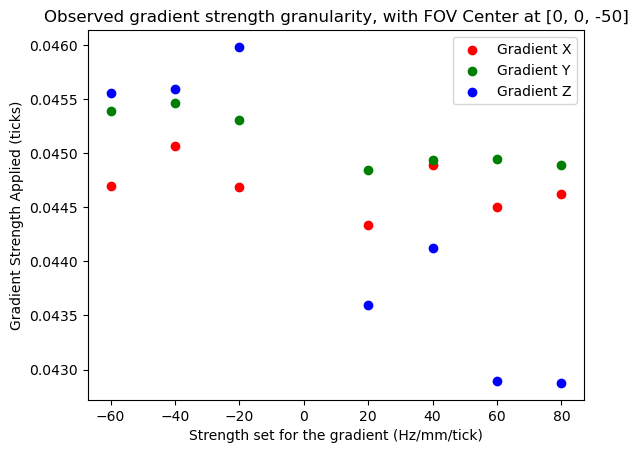

In [15]:
plotTickReferences(tickToGradStrengthsCEntered, centerPos)

In [20]:
def collectTickReferencesZgradient(gradientTicks, centerPos):
    tool.autoPrescanDone = False
    tool.exsiInstance.bedPosition = centerPos[2]
    tool.doFieldmapScan()
    latestDCMDir = listSubDirs(tool.localExamRootDir)[-1]
    firstDCM = listDicomFiles(latestDCMDir)[0]
    pixelSize = extractPixelSize(firstDCM)
    background = computeFieldmapFromLatestFieldmapScan(tool)
    print("=============================== Background Done ================================")
    slopes = []
    gradientToSet = [0,0,0]
    for ticks in tqdm.tqdm(gradientTicks, desc="Ticks", position=1):
        print(f"Doing gradient Z with ticks set to {ticks}")
        gradientToSet[2] = ticks
        tool.setLinGradients(gradientToSet)
        tool.doFieldmapScan()
        fieldmap = computeFieldmapFromLatestFieldmapScan(tool)
        fieldmap = fieldmap - background
        points = np.array(getFieldStrengthPoints(fieldmap, pixelSize, centerPos)[2])
        x = points[:,0]
        y = points[:,1]
        m, b = np.polyfit(x, y, 1)
        print(f"Gradient Z with ticks set to {ticks}: {m} Hz/mm ")
        print(f"\tGradient Z: {m/ticks} Hz/mm/tick")
        print("--------------------------------------------------------------")
        slopes.append([ticks, m/ticks])
    return np.array(slopes)

# plot the points from each gradient direction as a scatter plot with different colors. 
# on the x axis should be the strength set for the gradient, on the y axis should be the computed strength of the gradient per tick
# plot all three sets on the same graph

# Plot the points from each gradient direction as a scatter plot with different colors
def plotTickReferencesZ(slopes, centerFOV=[0,0,0]):
    plt.scatter(slopes[:, 0], slopes[:, 1], color='blue', label='Gradient Z')

    # Set labels and title
    plt.xlabel('Strength set for the gradient (Hz/mm/tick)')
    plt.ylabel('Gradient Strength Applied (ticks)')
    plt.title(f'Observed gradient strength granularity, with FOV Center at {centerFOV}')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

In [21]:
gradientTicks = list(range(-60,0,20)) + list(range(20,81,20))
centerPos = [0,0,-50]

In [22]:
zpoints = collectTickReferencesZgradient(gradientTicks, centerPos)

12:18:25 SHIM TOOL: resetting???
12:18:25 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:18:25 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
12:19:11 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:19:11 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:19:36 SHIM TOOL: Done. 2 scans completed!
12:19:36 SHIM TOOL: Initiating transfer using rsync.
12:19:37 SHIM TOOL: Initiating transfer using rsync.
12:19:37 SHIM TOOL: evaluating map 0
12:19:37 SHIM TOOL: finished setting the per slice stats for map 0
12:19:37 SHIM TOOL: finished setting the volume stats for map 0
12:19:37 SHIM TOOL: evaluating map 1
12:19:37 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBUG: Extracted te2 4.604, name2 nd
=============================== Background Done ======================

Doing gradient Z with ticks set to -60
12:19:38 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  12. -61.] to [   9.   12. -121.]
12:19:38 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:19:38 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
12:20:03 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:20:03 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:20:29 SHIM TOOL: Done. 2 scans completed!
12:20:29 SHIM TOOL: Initiating transfer using rsync.
12:20:30 SHIM TOOL: Initiating transfer using rsync.
12:20:31 SHIM TOOL: evaluating map 0
12:20:31 SHIM TOOL: finished setting the per slice stats for map 0
12:20:31 SHIM TOOL: finished setting the volume stats for map 0
12:20:31 SHIM TOOL: evaluating map 1
12:20:31 SHIM TOOL: evaluating map 2
DEBUG: Extracted te1 1.104, name1 st
DEBU

Gradient Z with ticks set to -60: -2.720500483382074 Hz/mm 
	Gradient Z: 0.04534167472303456 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to -40
12:20:32 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  12. -61.] to [   9.   12. -101.]
12:20:32 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:20:32 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
12:20:58 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:20:58 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:21:23 SHIM TOOL: Done. 2 scans completed!
12:21:23 SHIM TOOL: Initiating transfer using rsync.
12:21:24 SHIM TOOL: Initiating transfer using rsync.
12:21:24 SHIM TOOL: evaluating map 0
12:21:24 SHIM TOOL: finished setting the per slice stats for map 0
12:21:24 SHI

Gradient Z with ticks set to -40: -1.8130291807626953 Hz/mm 
	Gradient Z: 0.04532572951906738 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to -20
12:21:26 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  12. -61.] to [  9.  12. -81.]
12:21:26 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:21:26 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
12:21:51 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:21:51 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:22:16 SHIM TOOL: Done. 2 scans completed!
12:22:16 SHIM TOOL: Initiating transfer using rsync.
12:22:17 SHIM TOOL: Initiating transfer using rsync.
12:22:18 SHIM TOOL: evaluating map 0
12:22:18 SHIM TOOL: finished setting the per slice stats for map 0
12:22:18 SHIM 

Gradient Z with ticks set to -20: -0.9109489083296082 Hz/mm 
	Gradient Z: 0.04554744541648041 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 20
12:22:19 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  12. -61.] to [  9.  12. -41.]
12:22:19 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:22:19 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
12:22:44 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:22:44 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:23:09 SHIM TOOL: Done. 2 scans completed!
12:23:09 SHIM TOOL: Initiating transfer using rsync.
12:23:10 SHIM TOOL: Initiating transfer using rsync.
12:23:10 SHIM TOOL: evaluating map 0
12:23:10 SHIM TOOL: finished setting the per slice stats for map 0
12:23:10 SHIM T

Gradient Z with ticks set to 20: 0.8864382992355496 Hz/mm 
	Gradient Z: 0.04432191496177748 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 40
12:23:11 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  12. -61.] to [  9.  12. -21.]
12:23:11 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:23:11 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
12:23:37 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:23:37 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:24:03 SHIM TOOL: Done. 2 scans completed!
12:24:03 SHIM TOOL: Initiating transfer using rsync.
12:24:04 SHIM TOOL: Initiating transfer using rsync.
12:24:04 SHIM TOOL: evaluating map 0
12:24:04 SHIM TOOL: finished setting the per slice stats for map 0
12:24:04 SHIM TOO

Gradient Z with ticks set to 40: 1.775451634665664 Hz/mm 
	Gradient Z: 0.0443862908666416 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 60
12:24:05 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  12. -61.] to [ 9. 12. -1.]
12:24:05 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:24:05 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
12:24:31 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:24:31 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:24:56 SHIM TOOL: Done. 2 scans completed!
12:24:56 SHIM TOOL: Initiating transfer using rsync.
12:24:57 SHIM TOOL: Initiating transfer using rsync.
12:24:57 SHIM TOOL: evaluating map 0
12:24:57 SHIM TOOL: finished setting the per slice stats for map 0
12:24:57 SHIM TOOL: fi

Gradient Z with ticks set to 60: 2.5795854450358564 Hz/mm 
	Gradient Z: 0.04299309075059761 Hz/mm/tick
--------------------------------------------------------------
Doing gradient Z with ticks set to 80
12:24:58 SHIM TOOL: DEBUG: Setting linear gradients from [  9.  12. -61.] to [ 9. 12. 19.]
12:24:58 SHIM TOOL: Checking for failure on last run; On scan 1 / 2
12:24:58 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 1 / 2
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
plane is None, center is None
plane is coronal, center is [0.0, 0.0, -50]
12:25:24 SHIM TOOL: Checking for failure on last run; On scan 2 / 2
12:25:24 SHIM TOOL: No Fail. Waiting for scan to complete, On scan 2 / 2
12:25:50 SHIM TOOL: Done. 2 scans completed!
12:25:50 SHIM TOOL: Initiating transfer using rsync.
12:25:51 SHIM TOOL: Initiating transfer using rsync.
12:25:51 SHIM TOOL: evaluating map 0
12:25:51 SHIM TOOL: finished setting the per slice stats for map 0
12:25:51 SHIM TOOL: 

Ticks: 100%|██████████| 7/7 [06:14<00:00, 53.52s/it]

Gradient Z with ticks set to 80: 3.4415996270138485 Hz/mm 
	Gradient Z: 0.0430199953376731 Hz/mm/tick
--------------------------------------------------------------


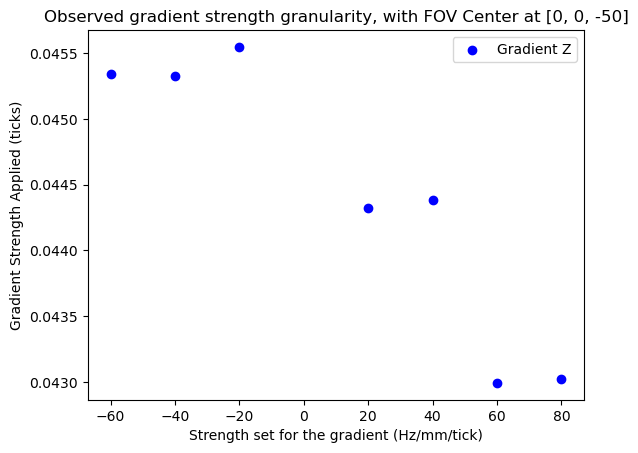

In [23]:
plotTickReferencesZ(zpoints, centerPos)

In [24]:
# get statistics for the z gradient
values = zpoints[:,1]
mean = np.mean(values)
std = np.std(values)
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")


Mean: 0.04441944879646744
Standard Deviation: 0.0009962645473480455


In [29]:
values = []
for i in range(3):
    tickToGradStrengthsCEntered[i] = np.array(tickToGradStrengthsCEntered[i])
    values += list(tickToGradStrengthsCEntered[i][:,1])
mean = np.mean(values)
std = np.std(values)
print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: 0.04472524313742108
Standard Deviation: 0.0007944906079856537
